## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

NH notes to self, delete before turning in: 

Class 5-3: 
- ngrams code and bar chart (bigrams, unigrams, 4 grams, etc.)
- warning: C:\Users\mackgsr1nvivo\anaconda3\envs\CSS\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've', 'xx', 'xxxx', 'xxxxxxxx'] not in stop_words.
  warnings.warn
      --> order of operations issue.
- feature engineering: adding variables length (character and word counts, polarity (pos and neg) and subjectivity (opinion basedness)
- LDA for text- binarize outcomes for predictors. if only two force as zeros and ones
- naive bayes called "multinomial nb" in the sklearn library. this is referring to the inputs, good for text analysi
- sentiment analysis: 5-2
- relevant non-text features: birthday, trump and obama share, genders- 


# Loading libraries, etc.

In [177]:
####fixes from internet for ImportError: cannot import name 'triu' from 'scipy.linalg'
##doesn't help
#from numpy import triu

##looks like scipy version 1.13.1 doesn't support "triu" so I guess I'm going to install an older version??
#!pip uninstall scipy verbose
#!pip install scipy==1.12


In [178]:
#pip show scipy

In [179]:
#!pip install contractions
import contractions

In [180]:
import scipy
print(scipy.__version__)

1.12.0


In [181]:
#1. pandas and numpy
import pandas as pd
import numpy as np

#some stuff I needed later
import re

In [182]:
#2. punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

In [183]:
#3. textblob
from textblob import TextBlob

In [184]:
#4. countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [185]:
#5. gensim -- this threw an error that I have no idea how to fix. "ImportError: cannot import name 'triu' from 'scipy.linalg'"
# Installing scipy 1.12 fixed that error.
import gensim
from gensim import models

In [186]:
#6. plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [299]:
#Others
from wordcloud import WordCloud
import scattertext as st
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [188]:
# #1. pandas and numpy
# import pandas as pd
# import numpy as np

# # punctuation, stop words and English language model
# from string import punctuation
# from spacy.lang.en.stop_words import STOP_WORDS
# import en_core_web_sm
# nlp = en_core_web_sm.load()

# # textblob
# from textblob import TextBlob

# # countvectorizer, tfidfvectorizer
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# # gensim
# import gensim
# from gensim import models

# # plotting
# import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline

In [189]:
# load data 
# ----------
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
#congress_tweets = congress_tweets.sample(...)
congress_tweets.head()

tweet_id screen_name                   datetime  \
0  1.081010e+18    RepByrne  2019-01-03T21:23:00-05:00   
1  1.080880e+18    RepByrne  2019-01-03T12:30:38-05:00   
2  1.080830e+18    RepByrne  2019-01-03T09:12:07-05:00   
3  1.080890e+18    RepByrne  2019-01-03T13:20:53-05:00   
4  1.080870e+18    RepByrne  2019-01-03T12:10:26-05:00   

                                                text name_wikipedia position  \
0  Great news for Baldwin County! The economy of ...  Bradley Byrne      Rep   
1  Outstanding news today from @Airbus! @JetBlue ...  Bradley Byrne      Rep   
2  RT @senatemajldr Democrats will have to get se...  Bradley Byrne      Rep   
3  Here is a sign of things to come: As Democrats...  Bradley Byrne      Rep   
4  Let's understand what we're dealing with here:...  Bradley Byrne      Rep   

  joined_congress_date   birthday gender state district_number       party  \
0             8-Jan-14  2/16/1955      M    AL               1  Republican   
1             8-Jan-14  2/16/1955      M    AL               1  Republican   
2             8-Jan-14  2/16/1955      M    AL               1  Republican   
3             8-Jan-14  2/16/1955      M    AL               1  Republican   
4             8-Jan-14  2/16/1955      M    AL               1  Republican   

  trump_2016_state_share clinton_2016_state_share obama_2012_state_share  \
0              1,318,255                  729,547                795,696   
1              1,318,255                  729,547                795,696   
2              1,318,255                  729,547                795,696   
3              1,318,255                  729,547                795,696   
4              1,318,255                  729,547                795,696   

  romney_2012_state_share  
0               1,255,925  
1               1,255,925  
2               1,255,925  
3               1,255,925  
4               1,255,925

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [190]:
type(congress_tweets)

pandas.core.frame.DataFrame

In [191]:
##subsetting the data for testing
# subset the first 100 rows
congress_tweets_100 = congress_tweets[:100]

In [192]:
#Going to reclass Angus King and Bernie as dems so there are two categories 
independent_screennames_unique = congress_tweets.loc[congress_tweets['party'] == 'Independent', 'screen_name'].drop_duplicates()
print(independent_screennames_unique)

368301    SenAngusKing
848770      SenSanders
Name: screen_name, dtype: object


In [193]:
unique_parties = congress_tweets['party'].unique()
print(unique_parties)

['Republican' 'Democrat' 'Independent']


In [194]:
congress_tweets['party'] = congress_tweets['party'].replace('Independent', 'Democrat')

In [195]:
unique_parties = congress_tweets['party'].unique()
print(unique_parties)

['Republican' 'Democrat']


In [196]:
#Position check
unique_pos = congress_tweets['position'].unique()
print(unique_pos)

['Rep' 'Sen']


### Redoing the code so that I just have one sample. I'm going to made sure the code runs with different samples of 100 and then use this chunk to control the sample size in the hope of getting onto collab at some point

In [197]:
##or random set of 100? setting a seed for repro
## change here if get more processing power.
np.random.seed(10)
ct_samp = congress_tweets.sample(n=5000)
ct_samp


tweet_id      screen_name                   datetime  \
36257   1.276160e+18         RepDavid  2020-06-25T10:22:13-04:00   
548996  1.082280e+18   RepSeanMaloney  2019-01-07T09:33:39-05:00   
652347  1.322270e+18   RepSteveChabot  2020-10-30T16:24:14-04:00   
267614  1.103730e+18     SenatorRisch  2019-03-07T13:33:23-05:00   
344386  1.097350e+18  RepThomasMassie  2019-02-17T23:35:06-05:00   
...              ...              ...                        ...   
808467  1.247970e+18    RepBrianBabin  2020-04-08T15:32:28-04:00   
708752  1.313910e+18   RepDwightEvans  2020-10-07T14:27:37-04:00   
7587    1.252290e+18    RepMarthaRoby  2020-04-20T13:41:44-04:00   
930878  1.088620e+18     RepSeanDuffy  2019-01-24T21:13:15-05:00   
277874  1.121820e+18    RepBillFoster  2019-04-26T13:03:41-04:00   

                                                     text  \
36257   Before adopting Olivia, we spent a great amoun...   
548996  Are we supposed to take Trump seriously or lit...   
652347  Thank you to Lieutenant Mike Tarr and Fire Chi...   
267614  Made remarks to @AmFreeSyria sharing my concer...   
344386  @jeroneanderson @MontcoLP @LelandShow @realDon...   
...                                                   ...   
808467  RT @Jim_Jordan House Democrats are already dem...   
708752  RT @SigneWilk Our super spreader president mot...   
7587    I'm confident Congress will act this week to r...   
930878  RT @LaurenBlanch12 Studied extra this week for...   
277874  Since 2000, the measles vaccine has saved over...   

              name_wikipedia position joined_congress_date   birthday gender  \
36257       David Schweikert      Rep             3-Jan-13   3/3/1962      M   
548996  Sean Patrick Maloney      Rep             3-Jan-13  7/30/1966      M   
652347          Steve Chabot      Rep             3-Jan-11  1/22/1953      M   
267614             Jim Risch      Sen             3-Jan-09   5/3/1943      M   
344386         Thomas Massie      Rep            13-Nov-12  1/13/1971      M   
...                      ...      ...                  ...        ...    ...   
808467           Brian Babin      Rep             3-Jan-15  3/23/1948      M   
708752          Dwight Evans      Rep            14-Nov-16  5/16/1954      M   
7587             Martha Roby      Rep             3-Jan-11  7/27/1976      F   
930878            Sean Duffy      Rep             3-Jan-11  10/3/1971      M   
277874           Bill Foster      Rep             3-Jan-13  10/7/1955      M   

       state district_number       party trump_2016_state_share  \
36257     AZ               6  Republican              1,252,401   
548996    NY              18    Democrat              2,819,533   
652347    OH               1  Republican              2,841,005   
267614    ID          Senate  Republican                409,055   
344386    KY               4  Republican              1,202,971   
...      ...             ...         ...                    ...   
808467    TX              36  Republican              4,685,047   
708752    PA               3    Democrat              2,970,733   
7587      AL               2  Republican              1,318,255   
930878    WI               7  Republican              1,405,284   
277874    IL              11    Democrat              2,146,015   

       clinton_2016_state_share obama_2012_state_share romney_2012_state_share  
36257                 1,161,167              1,025,232               1,233,654  
548996                4,556,118              4,485,741               2,490,431  
652347                2,394,164              2,827,709               2,661,437  
267614                  189,765                212,787                 420,911  
344386                  628,854                679,370               1,087,190  
...                         ...                    ...                     ...  
808467                3,877,868              3,308,124               4,569,843  
708752                2,926,441              2,9

In [198]:
## function: original code
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]

    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [199]:
##applying function to relevant column in ct_samp
ct_samp['tokens'] = ct_samp['text'].map(lambda x: rem_punc_stop(x)) # can use apply here 
ct_samp['tokens'] # visualize

36257     [Before, adopting, Olivia, spent, great, time,...
548996    [Are, supposed, Trump, seriously, literally, s...
652347    [Thank, Lieutenant, Mike, Tarr, Fire, Chief, O...
267614    [Made, remarks, AmFreeSyria, sharing, concern,...
344386    [jeroneanderson, MontcoLP, LelandShow, realDon...
                                ...                        
808467    [RT, JimJordan, House, Democrats, demanding, i...
708752    [RT, SigneWilk, Our, super, spreader, presiden...
7587      [I, m, confident, Congress, act, week, repleni...
930878    [RT, LaurenBlanch12, Studied, extra, week, Fin...
277874    [Since, 2000, measles, vaccine, saved, 21, mil...
Name: tokens, Length: 5000, dtype: object

In [200]:
##trying to look at the text to figure out how to pre-process
for text in ct_samp['text']:
    print(text)

Before adopting Olivia, we spent a great amount of time learning about Arizona’s foster care system and the different processes available for welcoming a child. I am pleased to see this Administration take action to support our Child Welfare System and foster youth. https://twitter.com/HHSGov/status/1275852190461165573 QT @HHSGov Learn more from @ACFHHS about how today's Executive Order (EO) strengthens America's child welfare system and aims to improve outcomes for children and families: https://www.acf.hhs.gov/media/press/2020/president-trump-signs-historic-child-welfare-executive-order?utm_source=TWITTER&utm_medium=TWITTER&utm_content=100001368435789&utm_campaign=Engagement&linkId=100000013147644 http://pbs.twimg.com/media/EbS8zkpXYAEOHO0.jpg
Are we supposed to take Trump seriously or literally on this "steel barrier" thing? Somebody call Peter Thiel.
Thank you to Lieutenant Mike Tarr and Fire Chief Ott Huber for the update and for all you do to keep us safe. http://pbs.twimg.com/me

In [201]:
for t in ct_samp['tokens']:
    print(t)

['Before', 'adopting', 'Olivia', 'spent', 'great', 'time', 'learning', 'Arizona', 'foster', 'care', 'system', 'different', 'processes', 'available', 'welcoming', 'child', 'I', 'pleased', 'Administration', 'action', 'support', 'Child', 'Welfare', 'System', 'foster', 'youth', 'QT', 'HHSGov', 'Learn', 'ACFHHS', 'todays', 'Executive', 'Order', 'EO', 'strengthens', 'Americas', 'child', 'welfare', 'system', 'aims', 'improve', 'outcomes', 'children', 'families']
['Are', 'supposed', 'Trump', 'seriously', 'literally', 'steel', 'barrier', 'thing', 'Somebody', 'Peter', 'Thiel']
['Thank', 'Lieutenant', 'Mike', 'Tarr', 'Fire', 'Chief', 'Ott', 'Huber', 'update', 'safe']
['Made', 'remarks', 'AmFreeSyria', 'sharing', 'concern', 'devastation', 'wrought', 'brutal', 'dictator', 'Assad', 'I', 'supported', 'S1', 'authorizes', 'sanctions', 'regime', ' ', 'Russian', 'amp', 'Iranian', 'backers', 'atrocities', 'civilians', 'I', 'urge', 'House', 'colleagues', 'swiftly']
['jeroneanderson', 'MontcoLP', 'LelandSho

#NH: Making edits to preprocessing here: 

Removing punctuation and stop words, removing mentions and hashtags, removing emojis (if possible!), removing http, lowercase. I think also maybe removing numbers, abbreviations, and quotation marks is a good idea. My computer is really slow so I think the more I remove the better off I'll be.  I guess I'll lemmatize for the same reason? 

Not sure what to do about entities. Going to leave them alone for now. 

On removing hashtags and mentions -- mentions I feel sure of, because while they illustrate sentiment and loyalty there's no real way to code which was the mention is going (support or recrimination) and what valence each account shows. Hashtags I'm less sure of -- a lot of time they are just filler (#TBT!) but sometimes they do show sentiment. But also, they are not spaced so I'm not sure spacy will deal with them as words or not? Could just be a huge lemmatization problem. And in general hastags only repeat sentiments already expressed in the body of the text, unless they are there for comedic effect. So I'm leaning towards getting rid of them. I might regret it though. 

In [202]:
##custom dictionary of random words I keep seeing in the random samples
abbreviations = {
    'qt': '', 
    'rt': '',    
    'amp': '',  
    's': '',  
    'n': ''  
}

##preprocessing function. Not sure if it's best practice to shove everything into this function, but it seems to work so I'm going for it.
##decided to lemmatize as well, hoping it'll make things quicker? 
def rem_punc_stop_lem(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)

    #Lowercase
    text = text.lower()

    # Expand contractions
    text = contractions.fix(text)

    # Remove fragments like 'l, 't, 's, etc.
    text = re.sub(r"'[a-zA-Z]+", "", text)

    # Remove abbreviations
    for abbr, replacement in abbreviations.items():
        text = re.sub(r'\b' + abbr + r'\b', replacement, text)
    
    # Tokenize 
    doc = nlp(text)
    
    # Extract/lemmatize while filtering out mentions (words that start with '@')
    lem_words = [token.lemma_ for token in doc if not token.text.startswith('@')]
    
    # Reconstruct text again without mentions
    text_no_mentions = " ".join(lem_words)

    # Remove punctuation 
    punc_free = "".join([ch for ch in text_no_mentions if ch not in punc])

    # Remove numbers
    punc_free = re.sub(r'\d+', '', punc_free) 

    #Remove emojis
    punc_free = re.sub(r'[^\x00-\x7F]+', '', punc_free) 

    #getting rid of random spaces and newline html stuff 
    punc_free = re.sub(r'\s+', ' ', punc_free)  # replace multiple spaces/newlines/tabs/etc with single space
    punc_free = punc_free.strip()  # remove leading/trailing 
    
    # Tokenize again
    doc = nlp(punc_free)

    # Extract 
    lem_words = [token.lemma_ for token in doc]

    # Remove words that start with 'http' (URLs)
    lem_words = [word for word in lem_words if not word.startswith('http')]

    # Remove stop words
    no_punc = [word for word in lem_words if word not in stop_words]

    return no_punc

In [203]:
# ##trying to expand results to get a look at what I've got. Not sure why some emojis have made it through...
# ## commenting this out to not redefine ct_samp

# np.random.seed(12)
# ct_samp = congress_tweets.sample(n=100)
# ct_samp['tokens'] = ct_samp['text'].map(lambda x: rem_punc_stop(x)) 
# for t in ct_samp['tokens']:
#     print(t)

In [204]:
# ## commenting this out to not redefine ct_samp
# np.random.seed(4)
# ct_samp = congress_tweets.sample(n=100)
# ct_samp['tokens'] = ct_samp['text'].map(lambda x: rem_punc_stop_lem(x)) 
# for t in ct_samp['tokens']:
#     print(t)

In [205]:
# np.random.seed(12)
# ct_samp = congress_tweets.sample(n=100)
# ct_samp['tokens'] = ct_samp['text'].map(lambda x: rem_punc_stop_lem(x)) 
# for t in ct_samp['tokens']:
#     print(t)

In [206]:
# # did lemmatizing do anything? (commenting out since lemmatizing worked and the comparison var is defunct. )
# subset_tokens = ct_samp[['tokens', 'tokens_lem']]
# print(subset_tokens)

In [207]:
###This is what I would do if my computer were faster and I could apply the function to the full data. 

# # ##applying function to full data
# congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop_lem(x))


In [208]:
#how many obs
congress_tweets.shape

(946791, 16)

In [209]:
# ## keeps timing out. Let's try with a bit more than 100
# #500 = 30 seconds
# #1000 = 1 minute
# #947,000 = 16 hours
# np.random.seed(12)
# ct_samp = congress_tweets.sample(n=1000)
# ct_samp['tokens'] = ct_samp['text'].map(lambda x: rem_punc_stop_lem(x)) 
ct_samp

tweet_id      screen_name                   datetime  \
36257   1.276160e+18         RepDavid  2020-06-25T10:22:13-04:00   
548996  1.082280e+18   RepSeanMaloney  2019-01-07T09:33:39-05:00   
652347  1.322270e+18   RepSteveChabot  2020-10-30T16:24:14-04:00   
267614  1.103730e+18     SenatorRisch  2019-03-07T13:33:23-05:00   
344386  1.097350e+18  RepThomasMassie  2019-02-17T23:35:06-05:00   
...              ...              ...                        ...   
808467  1.247970e+18    RepBrianBabin  2020-04-08T15:32:28-04:00   
708752  1.313910e+18   RepDwightEvans  2020-10-07T14:27:37-04:00   
7587    1.252290e+18    RepMarthaRoby  2020-04-20T13:41:44-04:00   
930878  1.088620e+18     RepSeanDuffy  2019-01-24T21:13:15-05:00   
277874  1.121820e+18    RepBillFoster  2019-04-26T13:03:41-04:00   

                                                     text  \
36257   Before adopting Olivia, we spent a great amoun...   
548996  Are we supposed to take Trump seriously or lit...   
652347  Thank you to Lieutenant Mike Tarr and Fire Chi...   
267614  Made remarks to @AmFreeSyria sharing my concer...   
344386  @jeroneanderson @MontcoLP @LelandShow @realDon...   
...                                                   ...   
808467  RT @Jim_Jordan House Democrats are already dem...   
708752  RT @SigneWilk Our super spreader president mot...   
7587    I'm confident Congress will act this week to r...   
930878  RT @LaurenBlanch12 Studied extra this week for...   
277874  Since 2000, the measles vaccine has saved over...   

              name_wikipedia position joined_congress_date   birthday gender  \
36257       David Schweikert      Rep             3-Jan-13   3/3/1962      M   
548996  Sean Patrick Maloney      Rep             3-Jan-13  7/30/1966      M   
652347          Steve Chabot      Rep             3-Jan-11  1/22/1953      M   
267614             Jim Risch      Sen             3-Jan-09   5/3/1943      M   
344386         Thomas Massie      Rep            13-Nov-12  1/13/1971      M   
...                      ...      ...                  ...        ...    ...   
808467           Brian Babin      Rep             3-Jan-15  3/23/1948      M   
708752          Dwight Evans      Rep            14-Nov-16  5/16/1954      M   
7587             Martha Roby      Rep             3-Jan-11  7/27/1976      F   
930878            Sean Duffy      Rep             3-Jan-11  10/3/1971      M   
277874           Bill Foster      Rep             3-Jan-13  10/7/1955      M   

       state district_number       party trump_2016_state_share  \
36257     AZ               6  Republican              1,252,401   
548996    NY              18    Democrat              2,819,533   
652347    OH               1  Republican              2,841,005   
267614    ID          Senate  Republican                409,055   
344386    KY               4  Republican              1,202,971   
...      ...             ...         ...                    ...   
808467    TX              36  Republican              4,685,047   
708752    PA               3    Democrat              2,970,733   
7587      AL               2  Republican              1,318,255   
930878    WI               7  Republican              1,405,284   
277874    IL              11    Democrat              2,146,015   

       clinton_2016_state_share obama_2012_state_share  \
36257                 1,161,167              1,025,232   
548996                4,556,118              4,485,741   
652347                2,394,164              2,827,709   
267614                  189,765                212,787   
344386                  628,854                679,370   
...                         ...                    ...   
808467                3,877,868              3,308,124   
708752                2,926,441              2,990,274   
7587                    729,547                795,696   
930878                1,382,536              1,620,985   
277874                3,090,729              3,019,512   


## Kasey - my computer is too slow. I'm going to stick with a tiny group unless I figure out how to get a remote server to work. I'll try to come to office hours for trouble shooting but my life is an insanity so that might not happen. Thanks for your flexibility!

In [210]:
#taking a look at the tokens in the group ; looks ok. 
for t in ct_samp['tokens']:
    print(t)

['Before', 'adopting', 'Olivia', 'spent', 'great', 'time', 'learning', 'Arizona', 'foster', 'care', 'system', 'different', 'processes', 'available', 'welcoming', 'child', 'I', 'pleased', 'Administration', 'action', 'support', 'Child', 'Welfare', 'System', 'foster', 'youth', 'QT', 'HHSGov', 'Learn', 'ACFHHS', 'todays', 'Executive', 'Order', 'EO', 'strengthens', 'Americas', 'child', 'welfare', 'system', 'aims', 'improve', 'outcomes', 'children', 'families']
['Are', 'supposed', 'Trump', 'seriously', 'literally', 'steel', 'barrier', 'thing', 'Somebody', 'Peter', 'Thiel']
['Thank', 'Lieutenant', 'Mike', 'Tarr', 'Fire', 'Chief', 'Ott', 'Huber', 'update', 'safe']
['Made', 'remarks', 'AmFreeSyria', 'sharing', 'concern', 'devastation', 'wrought', 'brutal', 'dictator', 'Assad', 'I', 'supported', 'S1', 'authorizes', 'sanctions', 'regime', ' ', 'Russian', 'amp', 'Iranian', 'backers', 'atrocities', 'civilians', 'I', 'urge', 'House', 'colleagues', 'swiftly']
['jeroneanderson', 'MontcoLP', 'LelandSho

In [211]:
### The first pass took a really long time, so I asked chatgpt to make the code more efficient. This was the result.  
### commenting out because this didn't help at all

# ##Load spaCy model once (for efficiency)
# nlp = spacy.load('en_core_web_sm', disable=["ner", "parser"])  # Disable unnecessary components

# # Precompile regex patterns for efficiency
# apostrophe_fragments = re.compile(r"'[a-zA-Z]+")  # Match contractions like 's, 't, etc.
# non_ascii_chars = re.compile(r"[^\x00-\x7F]+")  # Match emojis and non-ASCII characters
# extra_spaces = re.compile(r"\s+")  # Match multiple spaces

# # Custom dictionary of words to remove
# abbreviations = {'qt', 'rt', 'amp', 's', 'n'}

# def rem_punc_stop_lem_efficient(text):
#     """Preprocess text by lowercasing, removing contractions, lemmatizing, 
#     and filtering out stop words, punctuation, and unwanted elements."""
    
#     # Lowercase text
#     text = text.lower()

#     # Expand contractions (e.g., "he'd" -> "he would")
#     text = contractions.fix(text)

#     # Remove apostrophe fragments (e.g., 's, 't, etc.)
#     text = apostrophe_fragments.sub("", text)

#     # Tokenize and process text in **one pass**
#     doc = nlp(text)

#     # Extract & lemmatize words while filtering
#     lem_words = [
#         token.lemma_ for token in doc 
#         if not token.is_stop  # Remove stop words
#         and not token.is_punct  # Remove punctuation
#         and not token.text.startswith('@')  # Remove mentions (@user)
#         and not token.text.startswith('http')  # Remove URLs
#         and token.text not in abbreviations  # Remove custom words
#         and not token.is_digit  # Remove numbers
#     ]

#     # Remove non-ASCII characters (emojis)
#     punc_free = non_ascii_chars.sub("", " ".join(lem_words))

#     # Replace multiple spaces and strip leading/trailing whitespace
#     cleaned_text = extra_spaces.sub(" ", punc_free).strip()

#     return cleaned_text.split()  # Return as a list of tokens


## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1: word cloud

In [116]:
# np.random.seed(12)
# ct_samp = congress_tweets.sample(n=100)
# ct_samp['tokens'] = ct_samp['text'].map(lambda x: rem_punc_stop_lem(x)) 
# ct_samp

np.random.seed(12)
ct_samp_100 = congress_tweets.sample(n=100)
ct_samp_100['tokens'] = ct_samp_100['text'].map(lambda x: rem_punc_stop_lem(x)) 
ct_samp_100

np.random.seed(12)
ct_samp_1000 = congress_tweets.sample(n=1000)
ct_samp_1000['tokens'] = ct_samp_1000['text'].map(lambda x: rem_punc_stop_lem(x)) 
ct_samp_1000

tweet_id      screen_name                   datetime  \
121376  1.253430e+18         RepTjCox  2020-04-23T17:23:43-04:00   
532544  1.301630e+18    RepMalinowski  2020-09-03T17:07:49-04:00   
106318  1.221070e+18      RepBarragan  2020-01-25T09:01:51-05:00   
368459  1.093910e+18     SenAngusKing  2019-02-08T11:30:42-05:00   
853636  1.262360e+18       SenSanders  2020-05-18T08:42:19-04:00   
...              ...              ...                        ...   
868293  1.180100e+18    GerryConnolly  2019-10-04T08:48:46-04:00   
115963  1.242850e+18   RepScottPeters  2020-03-25T12:41:17-04:00   
541732  1.156540e+18    RepDebHaaland  2019-07-31T08:25:30-04:00   
431415  1.279190e+18    RepDebDingell  2020-07-03T19:23:38-04:00   
519447  1.223000e+18  SenatorMenendez  2020-01-30T16:55:56-05:00   

                                                     text    name_wikipedia  \
121376  Wishing a blessed month to all observing #Rama...            TJ Cox   
532544  Thank you to everyone who joined Tom’s Congres...    Tom Malinowski   
106318  #Impeachment case has been laid out clearly. T...  Nanette Barragán   
368459  From the Grand Canyon’s breathtaking size to Y...        Angus King   
853636  RT @RepJayapal This is exactly why @SenSanders...    Bernie Sanders   
...                                                   ...               ...   
868293  Some of my GOP colleagues tried to suggest to ...    Gerry Connolly   
115963  #ICYMI, #TaxDay has been moved: the due date f...      Scott Peters   
541732  Indigenous communities across the globe are fa...       Deb Haaland   
431415  It’s going to take all of us to beat this viru...    Debbie Dingell   
519447  WATCH: We know the Russian gov is preparing to...   Robert Menendez   

       position joined_congress_date    birthday gender state district_number  \
121376      Rep             3-Jan-19   7/18/1963      M    CA              21   
532544      Rep             3-Jan-19   9/23/1965      M    NJ               7   
106318      Rep             3-Jan-17   9/15/1976      F    CA              44   
368459      Sen             3-Jan-13   3/31/1944      M    ME          Senate   
853636      Sen             3-Jan-07    9/8/1941      M    VT          Senate   
...         ...                  ...         ...    ...   ...             ...   
868293      Rep             3-Jan-09   3/30/1950      M    VA              11   
115963      Rep             3-Jan-13   6/17/1958      M    CA              52   
541732      Rep             3-Jan-19   12/2/1960      F    NM               1   
431415      Rep             3-Jan-15  11/23/1953      F    MI              12   
519447      Sen            17-Jan-06    1/1/1954      M    NJ          Senate   

           party trump_2016_state_share clinton_2016_state_share  \
121376  Democrat              4,483,814                8,753,792   
532544  Democrat              1,601,933                2,148,278   
106318  Democrat              4,483,814                8,753,792   
368459  Democrat                335,593                  357,735   
853636  Democrat                 95,369                  178,573   
...          ...                    ...                      ...   
868293  Democrat              1,769,443                1,981,473   
115963  Democrat              4,483,814                8,753,792   
541732  Democrat                319,667                  385,234   
431415  Democrat              2,279,543                2,268,839   
519447  Democrat              1,601,933                2,148,278   

       obama_2012_state_share romney_2012_state_share  \
121376              7,854,285               4,839,958   
532544              2,125,101               1,477,568   
106318              7,854,285               4,839,958   
368459                401,306                 292,276   
853636                199,239                  92,698   
...                       ...                     ...   
868293              1,971,820               1,822,522   


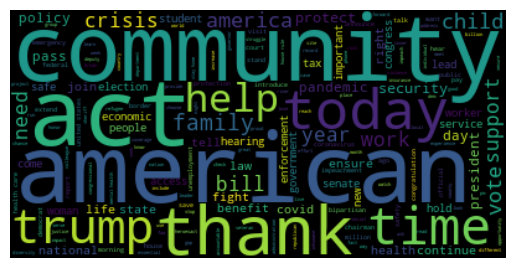

In [117]:
## Since I'm computationally challenged, I'm going to use the sample of 100 for this
# converting tokens to a string
text = ' '.join(ct_samp_100['tokens'].map(lambda text: ' '.join(text)))

# WordCloud viz
wordcloud = WordCloud(random_state=40).generate(text) # set random state to ensure same word cloud each time

# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

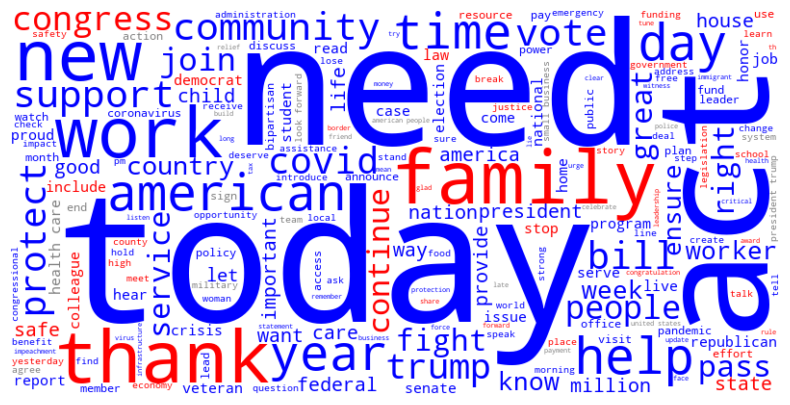

In [118]:
## trying again, this time colors by party and use 1000 observations

np.random.seed(12)
ct_samp_1000 = congress_tweets.sample(n=1000)
ct_samp_1000['tokens'] = ct_samp_1000['text'].map(lambda x: rem_punc_stop_lem(x)) 
ct_samp_1000

# Function to assign color based on party
def party_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    party = word_party_map.get(word, 'Neutral')  # Default to 'Neutral' if word isn't found
    return party_colors.get(party, 'gray')  # Default to gray if party isn't found

# Colors for each party
party_colors = {
    'Republican': 'red',
    'Democrat': 'blue',
    'Neutral': 'gray'
}

# Create a mapping of words to party affiliation
word_party_map = {}
for index, row in ct_samp_100.iterrows():
    words = row['tokens'] if isinstance(row['tokens'], list) else str(row['tokens']).split()
    party = row['party']
    for word in words:
        word_party_map[word] = party  # Assign each word its party

# Convert tokens column to a single string
text = ' '.join(ct_samp_1000['tokens'].map(lambda x: ' '.join(x) if isinstance(x, list) else str(x)))

# WordCloud
wordcloud = WordCloud(random_state=40, width=800, height=400, color_func=party_color_func,background_color='white').generate(text)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

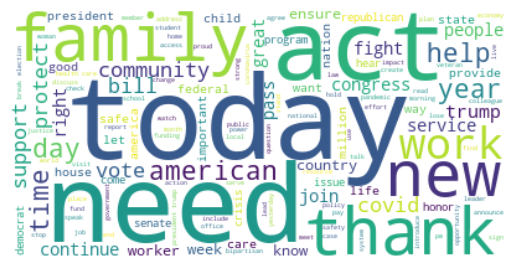

In [119]:
## Just going to see what happens with 5000
# converting tokens to a string
text = ' '.join(ct_samp_1000['tokens'].map(lambda text: ' '.join(text)))

# WordCloud viz
wordcloud = WordCloud(random_state=40,background_color='white').generate(text) # set random state to ensure same word cloud each time

# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

### EDA 2: Scattertext

In [120]:
# Scattertext 1
# sample of 100
##cleaning party column
#NAs
ct_samp_100 = ct_samp_100.dropna(subset=['party'])
#categorical
ct_samp_100['party'] = ct_samp_100['party'].astype('category')
print(ct_samp_100['party'].isna().sum())  # Ensure there are no missing values

0


In [121]:
# Scattertext 2
# create measure with sample of 100
#make a string to avoid value error
ct_samp_100['tokens'] = ct_samp_100['tokens'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)


corpus = st.CorpusFromPandas(ct_samp_100,              # specify data 
                             category_col = 'party',   # specify the explanatory variable (how it'll be split)  
                             text_col = 'tokens',      # specify the text column
                             nlp = nlp).build()        # apply the nlp algorithim and build

# create html document
html = st.produce_scattertext_explorer(corpus,  
                                       category='Republican',  # Category 1
                                       category_name='Republican',  # label category 1
                                       not_category_name='Democrat',  # Category 2
                                       width_in_pixels=1000,  
                                       minimum_term_frequency=5,  # Only include terms that appear at least 5 times?
                                       metadata=ct_samp_100['tweet_id'])  # Use "tweet_id" as id 

In [122]:
# Scattertext 3
# Save the HTML content to a file sample of 100
with open("Tweets_Sentiment.html", 'w', encoding='utf-8') as f:
    f.write(html)

# Automatically open the HTML file in the default browser
import webbrowser
webbrowser.open("Tweets_Sentiment.html")


True

In [123]:
# Scattertext 1
# sample of 1000
##cleaning party column
#NAs
ct_samp_1000 = ct_samp_1000.dropna(subset=['party'])
#categorical
ct_samp_1000['party'] = ct_samp_1000['party'].astype('category')
print(ct_samp_1000['party'].isna().sum())  # Ensure there are no missing values

#missing
print(ct_samp_1000.isnull().sum())
ct_samp_1000 = ct_samp_1000.dropna(subset=['tokens', 'party', 'tweet_id'])



0
tweet_id                    0
screen_name                 0
datetime                    0
text                        0
name_wikipedia              0
position                    0
joined_congress_date        0
birthday                    0
gender                      0
state                       0
district_number             0
party                       0
trump_2016_state_share      0
clinton_2016_state_share    0
obama_2012_state_share      0
romney_2012_state_share     0
tokens                      0
dtype: int64


In [124]:
# debugging -- length is off for some reason
print(len(ct_samp_1000), len(ct_samp_1000['tweet_id']))
print(ct_samp_1000.dtypes)
ct_samp_1000['tweet_id'] = ct_samp_1000['tweet_id'].astype(str)
print(ct_samp_1000.dtypes)

1000 1000
tweet_id                     float64
screen_name                   object
datetime                      object
text                          object
name_wikipedia                object
position                      object
joined_congress_date          object
birthday                      object
gender                        object
state                         object
district_number               object
party                       category
trump_2016_state_share        object
clinton_2016_state_share      object
obama_2012_state_share        object
romney_2012_state_share       object
tokens                        object
dtype: object
tweet_id                      object
screen_name                   object
datetime                      object
text                          object
name_wikipedia                object
position                      object
joined_congress_date          object
birthday                      object
gender                        object
state         

In [125]:
#more debugging -- length is off for some reason
print(len(corpus.get_df()), len(ct_samp_1000['tweet_id']))
print((ct_samp_1000['tokens'] == '').sum())  # Count empty strings
print((ct_samp_1000['tokens'].str.strip() == '').sum())  # Count spaces-only strings
ct_samp_1000 = ct_samp_1000[ct_samp_1000['tokens'].str.strip() != '']
print(len(corpus.get_df()), len(ct_samp_1000['tweet_id']))


100 1000
0
0
100 1000


In [126]:
print(ct_samp_1000.isnull().sum())
print(ct_samp_1000['party'].value_counts())
ct_samp_1000 = ct_samp_1000.reset_index(drop=True)

tweet_id                    0
screen_name                 0
datetime                    0
text                        0
name_wikipedia              0
position                    0
joined_congress_date        0
birthday                    0
gender                      0
state                       0
district_number             0
party                       0
trump_2016_state_share      0
clinton_2016_state_share    0
obama_2012_state_share      0
romney_2012_state_share     0
tokens                      0
dtype: int64
party
Democrat      668
Republican    332
Name: count, dtype: int64


In [127]:
#ok fixed now I think
print(len(corpus.get_df()), len(ct_samp_1000['tweet_id']))


100 1000


In [128]:
# # Scattertext 2
# # create measure with sample of 1000
# #make a string to avoid value error
# # this sometimes works and sometimes doesn't, not sure why
# ct_samp_1000['tokens'] = ct_samp_1000['tokens'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)


# corpus = st.CorpusFromPandas(ct_samp_1000,              # specify data 
#                              category_col = 'party',   # specify the explanatory variable (how it'll be split)  
#                              text_col = 'tokens',      # specify the text column
#                              nlp = nlp).build()        # apply the nlp algorithim and build

# # create html document
# html = st.produce_scattertext_explorer(corpus,  
#                                        category='Republican',  # Category 1
#                                        category_name='Republican',  # label category 1
#                                        not_category_name='Democrat',  # Category 2
#                                        width_in_pixels=1000,  
#                                        minimum_term_frequency=5,  # Only include terms that appear at least 5 times?
#                                        metadata=ct_samp_1000['tweet_id'])  # Use "tweet_id" as id 

In [129]:
# Scattertext 3
# Save the HTML content to a file sample of 1000
with open("Tweets_Sentiment.html", 'w', encoding='utf-8') as f:
    f.write(html)

# Automatically open the HTML file in the default browser
import webbrowser
webbrowser.open("Tweets_Sentiment.html")


True

In [130]:
# list of common words
# Step 1: Create a dictionary to store word frequencies by category
word_freq = {'Rep-Sen': {}, 'Rep-Rep': {}, 'Dem-Sen': {}, 'Dem-Rep': {}}

# Step 2: Process each row in your dataset and update word frequencies
for _, row in ct_samp_100.iterrows():
    words = row['tokens'] if isinstance(row['tokens'], list) else str(row['tokens']).split()
    category = f"{row['party'][:3]}-{row['position'][:3]}"  # Format: "Rep-Sen", "Dem-Rep", etc.

    for word in words:
        if word in word_freq[category]:
            word_freq[category][word] += 1
        else:
            word_freq[category][word] = 1

# Step 3: Get the top 5 most frequent words in each category
top_words = {}
for category, words in word_freq.items():
    # Sort words in descending order by frequency and get the top 5
    sorted_words = sorted(words.items(), key=lambda x: x[1], reverse=True)[:50]
    top_words[category] = sorted_words

# Step 4: Print the top 5 words in each category
for category, words in top_words.items():
    print(f"\nTop 5 words in category '{category}':")
    for word, freq in words:
        print(f"  - {word}: {freq}")



Top 5 words in category 'Rep-Sen':
  - student: 2
  - high: 2
  - chance: 2
  - procedural: 2
  - motion: 2
  - vote: 2
  - policy: 2
  - ralph: 2
  - service: 2
  - marshal: 2
  - arrest: 2
  - good: 1
  - luck: 1
  - brooke: 1
  - university: 1
  - compete: 1
  - technology: 1
  - competition: 1
  - week: 1
  - westvirginiaproud: 1
  - senschumer: 1
  - colleague: 1
  - second: 1
  - begin: 1
  - consider: 1
  - package: 1
  - bipartisan: 1
  - fashion: 1
  - decide: 1
  - prioritize: 1
  - partisan: 1
  - wish: 1
  - list: 1
  - life: 1
  - wellbee: 1
  - american: 1
  - people: 1
  - fail: 1
  - senate: 1
  - democrats: 1
  - negotiate: 1
  - trump: 1
  - administration: 1
  - coronavirus: 1
  - bill: 1
  - statement: 1
  - yale: 1
  - law: 1
  - school: 1
  - discrimination: 1

Top 5 words in category 'Rep-Rep':
  - I: 9
  - thank: 5
  - work: 4
  - security: 3
  - sheriff: 3
  - deputy: 3
  - state: 3
  - fight: 3
  - national: 3
  - project: 3
  - house: 3
  - rule: 3
  - chair

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?

I tried Tammy Baldwin and Tom Cotton, and then tried Kamala as well, using a sample of 5000. In both cases the dem is slightly more negative. Tom Cotton's tweets seem to be fairly neutral, and it isn't surprising that two well-known opposition party folks might be a bit more negative during the first Trump term. 

* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives

In the Rep vs Dem plot, they are pretty similar in terms of sentiment for the sample of 5000; the dems are ever so slightly less positive. 

For the Sen vs Rep plot, I also used a sample of 5000, and they were extremely similar. 

`TextBlob` has already been imported in the top cell.

In [ ]:
#get list of folks to choose from
unique_parties = congress_tweets['name_wikipedia'].unique()
print(unique_parties)

In [212]:
#Adding a column with polarity -- using small sample for first run through
#text = ' '.join(ct_samp['tokens'].map(lambda text: ' '.join(text)))
ct_samp['polarity'] = ct_samp['tokens'].map(lambda tokens: TextBlob(' '.join(tokens)).sentiment.polarity)
#ct_samp['polarity'] = ct_samp['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
ct_samp

tweet_id      screen_name                   datetime  \
36257   1.276160e+18         RepDavid  2020-06-25T10:22:13-04:00   
548996  1.082280e+18   RepSeanMaloney  2019-01-07T09:33:39-05:00   
652347  1.322270e+18   RepSteveChabot  2020-10-30T16:24:14-04:00   
267614  1.103730e+18     SenatorRisch  2019-03-07T13:33:23-05:00   
344386  1.097350e+18  RepThomasMassie  2019-02-17T23:35:06-05:00   
...              ...              ...                        ...   
808467  1.247970e+18    RepBrianBabin  2020-04-08T15:32:28-04:00   
708752  1.313910e+18   RepDwightEvans  2020-10-07T14:27:37-04:00   
7587    1.252290e+18    RepMarthaRoby  2020-04-20T13:41:44-04:00   
930878  1.088620e+18     RepSeanDuffy  2019-01-24T21:13:15-05:00   
277874  1.121820e+18    RepBillFoster  2019-04-26T13:03:41-04:00   

                                                     text  \
36257   Before adopting Olivia, we spent a great amoun...   
548996  Are we supposed to take Trump seriously or lit...   
652347  Thank you to Lieutenant Mike Tarr and Fire Chi...   
267614  Made remarks to @AmFreeSyria sharing my concer...   
344386  @jeroneanderson @MontcoLP @LelandShow @realDon...   
...                                                   ...   
808467  RT @Jim_Jordan House Democrats are already dem...   
708752  RT @SigneWilk Our super spreader president mot...   
7587    I'm confident Congress will act this week to r...   
930878  RT @LaurenBlanch12 Studied extra this week for...   
277874  Since 2000, the measles vaccine has saved over...   

              name_wikipedia position joined_congress_date   birthday gender  \
36257       David Schweikert      Rep             3-Jan-13   3/3/1962      M   
548996  Sean Patrick Maloney      Rep             3-Jan-13  7/30/1966      M   
652347          Steve Chabot      Rep             3-Jan-11  1/22/1953      M   
267614             Jim Risch      Sen             3-Jan-09   5/3/1943      M   
344386         Thomas Massie      Rep            13-Nov-12  1/13/1971      M   
...                      ...      ...                  ...        ...    ...   
808467           Brian Babin      Rep             3-Jan-15  3/23/1948      M   
708752          Dwight Evans      Rep            14-Nov-16  5/16/1954      M   
7587             Martha Roby      Rep             3-Jan-11  7/27/1976      F   
930878            Sean Duffy      Rep             3-Jan-11  10/3/1971      M   
277874           Bill Foster      Rep             3-Jan-13  10/7/1955      M   

       state district_number       party trump_2016_state_share  \
36257     AZ               6  Republican              1,252,401   
548996    NY              18    Democrat              2,819,533   
652347    OH               1  Republican              2,841,005   
267614    ID          Senate  Republican                409,055   
344386    KY               4  Republican              1,202,971   
...      ...             ...         ...                    ...   
808467    TX              36  Republican              4,685,047   
708752    PA               3    Democrat              2,970,733   
7587      AL               2  Republican              1,318,255   
930878    WI               7  Republican              1,405,284   
277874    IL              11    Democrat              2,146,015   

       clinton_2016_state_share obama_2012_state_share  \
36257                 1,161,167              1,025,232   
548996                4,556,118              4,485,741   
652347                2,394,164              2,827,709   
267614                  189,765                212,787   
344386                  628,854                679,370   
...                         ...                    ...   
808467                3,877,868              3,308,124   
708752                2,926,441              2,990,274   
7587                    729,547                795,696   
930878                1,382,536              1,620,985   
277874                3,090,729              3,019,512   


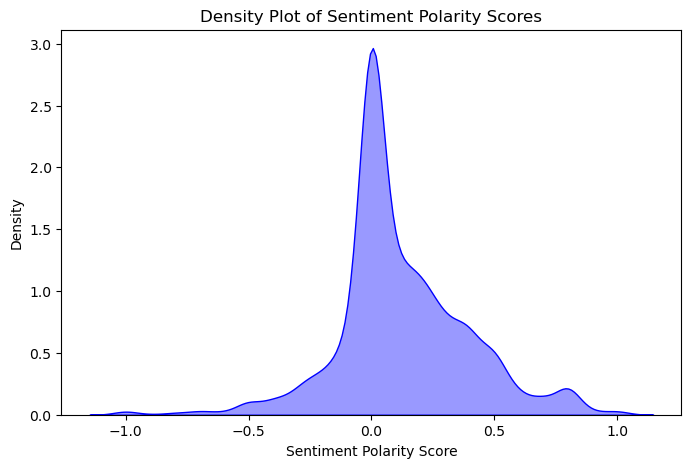

In [213]:

plt.figure(figsize=(8, 5))
sns.kdeplot(ct_samp["polarity"], fill=True, color="blue", alpha=0.4)

# Add labels and title
plt.xlabel("Sentiment Polarity Score")
plt.ylabel("Density")
plt.title("Density Plot of Sentiment Polarity Scores")

# Show plot
plt.show()


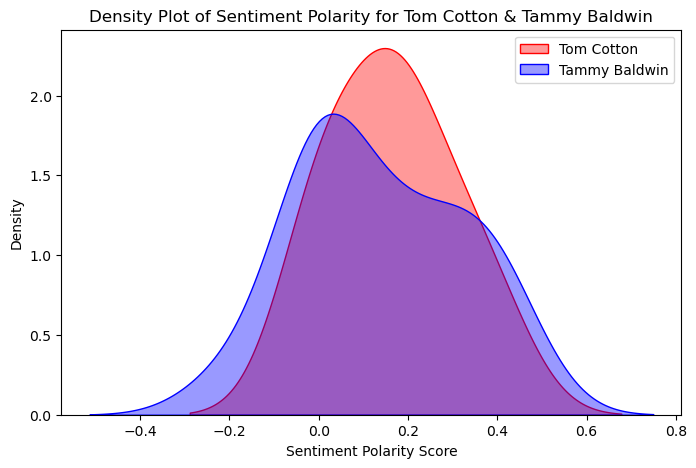

In [218]:
#Tammy Baldwin vs. Tom Cotton 

# Filter the DataFrame for only "Tom Cotton" and "Tammy Baldwin"
ct_samp_filtered = ct_samp[ct_samp["name_wikipedia"].isin(["Tom Cotton", "Tammy Baldwin"])]

# Create the density plot
plt.figure(figsize=(8, 5))
sns.kdeplot(ct_samp_filtered[ct_samp_filtered["name_wikipedia"] == "Tom Cotton"]["polarity"], 
            fill=True, color="red", alpha=0.4, label="Tom Cotton")
sns.kdeplot(ct_samp_filtered[ct_samp_filtered["name_wikipedia"] == "Tammy Baldwin"]["polarity"], 
            fill=True, color="blue", alpha=0.4, label="Tammy Baldwin")

# Add labels, legend, and title
plt.xlabel("Sentiment Polarity Score")
plt.ylabel("Density")
plt.title("Density Plot of Sentiment Polarity for Tom Cotton & Tammy Baldwin")
plt.legend()

# Show the plot
plt.show()

#Looks like Tammy isn't in my small sample. Trying again with a bigger one 


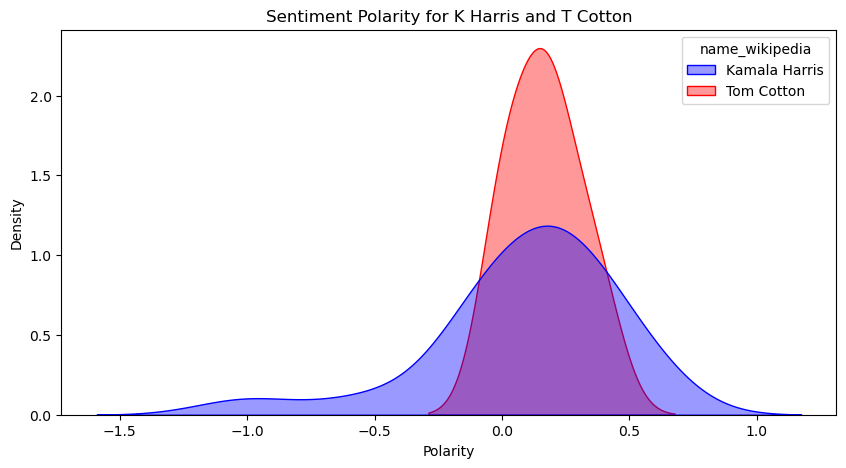

In [216]:

# Set a random seed for reproducibility
np.random.seed(42)

# Filter for only "Tom Cotton" and "Kamala Harris." Was kind of hard to find a Dem who tweets enough to keep up with Tom Cotton
ofint = ["Tom Cotton", "Kamala Harris"]
#desperately trying to get this thing to layer properly
custom_palette = {"Tom Cotton": "red", "Kamala Harris": "blue"}

ct_samp_filtered = ct_samp[ct_samp["name_wikipedia"].isin(["Tom Cotton", "Kamala Harris"])]

#density plot
plt.figure(figsize=(10, 5))
sns.kdeplot(data=ct_samp_filtered, x="polarity", hue="name_wikipedia", 
            fill=True, alpha=0.4, palette=custom_palette, common_norm=False)

# Customize labels and title
plt.title("Sentiment Polarity for K Harris and T Cotton")
plt.xlabel("Polarity")
plt.ylabel("Density")

# Show plot
plt.show()

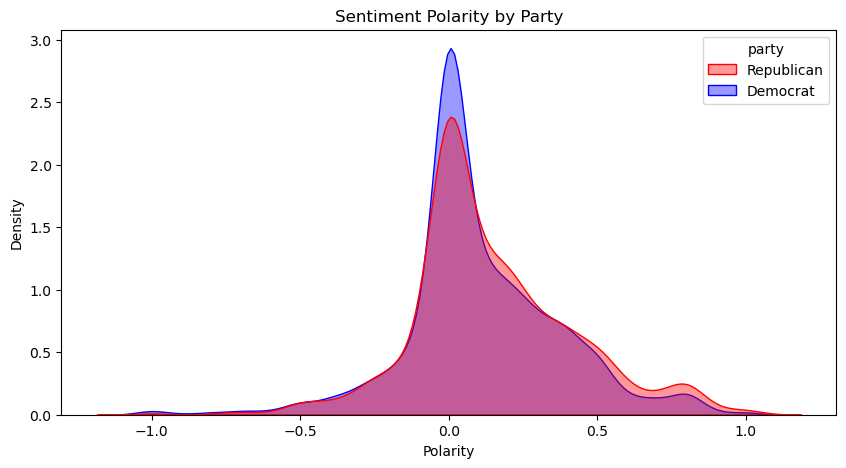

In [221]:
# Set a random seed for reproducibility
np.random.seed(42)

custom_palette = {"Republican": "red", "Democrat": "blue"}

#density plot
plt.figure(figsize=(10, 5))
sns.kdeplot(data=ct_samp, x="polarity", hue="party", 
            fill=True, alpha=0.4, palette=custom_palette, common_norm=False)

# Customize labels and title
plt.title("Sentiment Polarity by Party")
plt.xlabel("Polarity")
plt.ylabel("Density")

# Show plot
plt.show()

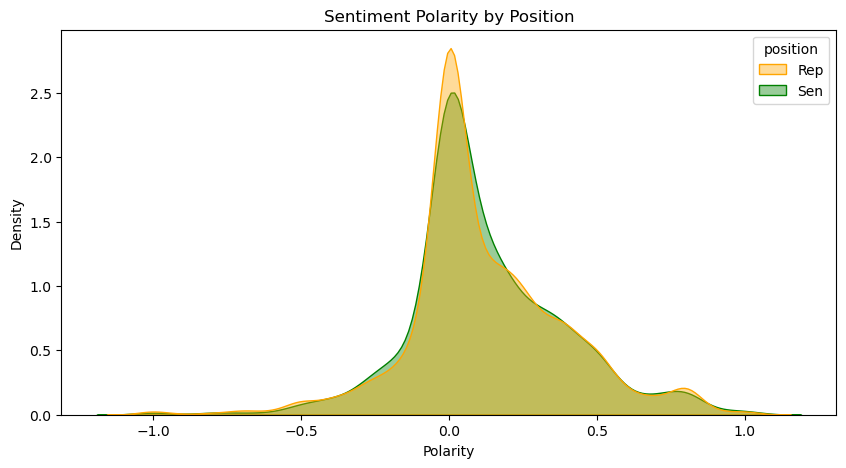

In [223]:
# Set a random seed for reproducibility
np.random.seed(42)

custom_palette = {"Rep": "orange", "Sen": "green"}

#density plot
plt.figure(figsize=(10, 5))
sns.kdeplot(data=ct_samp, x="polarity", hue="position", 
            fill=True, alpha=0.4, palette=custom_palette, common_norm=False)

# Customize labels and title
plt.title("Sentiment Polarity by Position")
plt.xlabel("Polarity")
plt.ylabel("Density")

# Show plot
plt.show()

# Responses: \

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?

* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

Trying to get straight how many variable to include in the training data. the full data has a lot of variables it doesn't seem to make sense to keep. Going to take a subset now so it doesn't get confusing later. 

In [224]:
column_names = ct_samp.columns.tolist()

print(column_names)

['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia', 'position', 'joined_congress_date', 'birthday', 'gender', 'state', 'district_number', 'party', 'trump_2016_state_share', 'clinton_2016_state_share', 'obama_2012_state_share', 'romney_2012_state_share', 'tokens', 'polarity']


In [225]:
ct_samp = ct_samp.drop(columns=['tweet_id', 'screen_name', 'datetime','name_wikipedia','district_number'])

ct_samp

text position  \
36257   Before adopting Olivia, we spent a great amoun...      Rep   
548996  Are we supposed to take Trump seriously or lit...      Rep   
652347  Thank you to Lieutenant Mike Tarr and Fire Chi...      Rep   
267614  Made remarks to @AmFreeSyria sharing my concer...      Sen   
344386  @jeroneanderson @MontcoLP @LelandShow @realDon...      Rep   
...                                                   ...      ...   
808467  RT @Jim_Jordan House Democrats are already dem...      Rep   
708752  RT @SigneWilk Our super spreader president mot...      Rep   
7587    I'm confident Congress will act this week to r...      Rep   
930878  RT @LaurenBlanch12 Studied extra this week for...      Rep   
277874  Since 2000, the measles vaccine has saved over...      Rep   

       joined_congress_date   birthday gender state       party  \
36257              3-Jan-13   3/3/1962      M    AZ  Republican   
548996             3-Jan-13  7/30/1966      M    NY    Democrat   
652347             3-Jan-11  1/22/1953      M    OH  Republican   
267614             3-Jan-09   5/3/1943      M    ID  Republican   
344386            13-Nov-12  1/13/1971      M    KY  Republican   
...                     ...        ...    ...   ...         ...   
808467             3-Jan-15  3/23/1948      M    TX  Republican   
708752            14-Nov-16  5/16/1954      M    PA    Democrat   
7587               3-Jan-11  7/27/1976      F    AL  Republican   
930878             3-Jan-11  10/3/1971      M    WI  Republican   
277874             3-Jan-13  10/7/1955      M    IL    Democrat   

       trump_2016_state_share clinton_2016_state_share obama_2012_state_share  \
36257               1,252,401                1,161,167              1,025,232   
548996              2,819,533                4,556,118              4,485,741   
652347              2,841,005                2,394,164              2,827,709   
267614                409,055                  189,765                212,787   
344386              1,202,971                  628,854                679,370   
...                       ...                      ...                    ...   
808467              4,685,047                3,877,868              3,308,124   
708752              2,970,733                2,926,441              2,990,274   
7587                1,318,255                  729,547                795,696   
930878              1,405,284                1,382,536              1,620,985   
277874              2,146,015                3,090,729              3,019,512   

       romney_2012_state_share  \
36257                1,233,654   
548996               2,490,431   
652347               2,661,437   
267614                 420,911   
344386               1,087,190   
...                        ...   
808467               4,569,843   
708752               2,680,434   
7587                 1,255,925   
930878               1,407,966   
277874               2,135,216   

                                                   tokens  polarity  
36257   [Before, adopting, Olivia, spent, great, time,...  0.283333  
548996  [Are, supposed, Trump, seriously, literally, s... -0.333333  
652347  [Thank, Lieutenant, Mike, Tarr, Fire, Chief, O...  0.500000  
267614  [Made, remarks, AmFreeSyria, sharing, concern,... -0.437500  
344386  [jeroneanderson, MontcoLP, LelandShow, realDon...  0.000000  
...                                                   ...       ...  
808467  [RT, JimJordan, House, Democrats, demanding, i... -0.277778  
708752  [RT, SigneWilk, Our, super, spreader, presiden...  0.333333  
7587    [I, m, confident, Congress, act, week, repleni... -0.037500  
930878  [RT, LaurenBlanch12, Studied, extra, week, Fin...  0.000000  
277874  [Since, 2000, measles, vaccine, saved, 21, mil...  0.000000  

[5000 rows x 13 columns]

### Engineered Text Features

In [226]:
# function to extract character count, word count, polarity, and subjectivity
def engfeat_func(tokens):
    text = ' '.join(tokens)  # Convert token list into a string. This is an important step that I keep having to add
    blob = TextBlob(text)  
    character_count = len(text)  # char count
    word_count = len(tokens)  # word count 
    polarity = blob.sentiment.polarity  # sentiment polarity
    subjectivity = blob.sentiment.subjectivity  # subjectivity 

    return pd.Series([character_count, word_count, polarity, subjectivity], 
                     index=['char_count', 'word_count', 'polarity', 'subjectivity'])

# Apply the function to the 'tokens' column
engfeat = ct_samp['tokens'].apply(engfeat_func)

# Combine this with the original DataFrame (if needed)
ct_samp_with_engfeat = pd.concat([ct_samp, engfeat], axis=1)

# Display the first few rows of the new DataFrame
print(ct_samp_with_engfeat.head())


                                                     text position  \
36257   Before adopting Olivia, we spent a great amoun...      Rep   
548996  Are we supposed to take Trump seriously or lit...      Rep   
652347  Thank you to Lieutenant Mike Tarr and Fire Chi...      Rep   
267614  Made remarks to @AmFreeSyria sharing my concer...      Sen   
344386  @jeroneanderson @MontcoLP @LelandShow @realDon...      Rep   

       joined_congress_date   birthday gender state       party  \
36257              3-Jan-13   3/3/1962      M    AZ  Republican   
548996             3-Jan-13  7/30/1966      M    NY    Democrat   
652347             3-Jan-11  1/22/1953      M    OH  Republican   
267614             3-Jan-09   5/3/1943      M    ID  Republican   
344386            13-Nov-12  1/13/1971      M    KY  Republican   

       trump_2016_state_share clinton_2016_state_share obama_2012_state_share  \
36257               1,252,401                1,161,167              1,025,232   
548996        

### Bag-of-words or Tf-idf

In [227]:
# getting "matrix" which just has tf-idf values
ct_samp['tokens_str'] = ct_samp['tokens'].apply(lambda tokens: ' '.join(tokens))

# Frequency Based featurization
tfidf_vector = TfidfVectorizer(tokenizer = rem_punc_stop_lem, # using function already defined above
                               token_pattern = None) 
tfidf_vector

# fit and transform just a subset of our data
# ----------
# fit and transform to obtain the tfidf matrix
matrix = tfidf_vector.fit_transform(ct_samp['tokens_str'])

# feature names and check the length
feature_names = tfidf_vector.get_feature_names_out()
len(feature_names)

14510

In [228]:
#Push back into model for second df called ct_samp_with_tfidf
# Convert TF-IDF matrix to a Pandas DataFrame
tfidf_df = pd.DataFrame(matrix.toarray(), columns=tfidf_vector.get_feature_names_out())

# Merge TF-IDF features with the original dataframe (ensuring same index)
ct_samp_with_tfidf = pd.concat([ct_samp.reset_index(drop=True), tfidf_df], axis=1)

# Check the updated DataFrame
print(ct_samp_with_tfidf.head())


                                                text position  \
0  Before adopting Olivia, we spent a great amoun...      Rep   
1  Are we supposed to take Trump seriously or lit...      Rep   
2  Thank you to Lieutenant Mike Tarr and Fire Chi...      Rep   
3  Made remarks to @AmFreeSyria sharing my concer...      Sen   
4  @jeroneanderson @MontcoLP @LelandShow @realDon...      Rep   

  joined_congress_date   birthday gender state       party  \
0             3-Jan-13   3/3/1962      M    AZ  Republican   
1             3-Jan-13  7/30/1966      M    NY    Democrat   
2             3-Jan-11  1/22/1953      M    OH  Republican   
3             3-Jan-09   5/3/1943      M    ID  Republican   
4            13-Nov-12  1/13/1971      M    KY  Republican   

  trump_2016_state_share clinton_2016_state_share obama_2012_state_share  ...  \
0              1,252,401                1,161,167              1,025,232  ...   
1              2,819,533                4,556,118              4,485,741  

### Word Embedding

In [229]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

word2vec_model = gensim.models.KeyedVectors.load_word2vec_format("C:/git/CSSTP/5 Natural Language Processing/5-4 word2vec/data/GoogleNews-vectors-negative300.bin", binary = True) 

In [230]:
# # Kasey: I had a lot of issues with gitignore and pushing data to github during class, so I'm not going to copy this model into my project folder.
# # I hope that doesn't mess anything up for you when you try to run this, I assume you have the model on your computer. 

# # Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
# # nb: model.vocab is deprecated, model needs to match
# def document_vector(word2vec_model, doc):
#     doc = [word for word in doc if word in model.vocab]
#     return np.mean(model[doc], axis=0)

# the code above didn't work bc model.vocab is deprecated. Chatgpt says to do this instead:
def document_vector(word2vec_model, doc):
    """Compute the mean word vector for a document."""
    # Filter words that exist in the model's vocabulary
    valid_words = [word for word in doc if word in word2vec_model.key_to_index]
    
    if not valid_words:  # Handle case where no words in doc are in the model
        return np.zeros(word2vec_model.vector_size)
    
    # Compute the mean of the word vectors
    return np.mean([word2vec_model[word] for word in valid_words], axis=0)


In [231]:
# embedding based featurization 
# getting "doc_vectors"
# apply the function to compute document vectors
doc_vectors = ct_samp['tokens'].apply(lambda x: document_vector(word2vec_model, x))

# Converting to an array seems to be important, not sure why 
doc_vectors = np.vstack(doc_vectors.values)

doc_vectors.shape

(5000, 300)

In [232]:
#putting these back into ct_samp for ct_samp_with_doc_vector

# Step 1: Convert doc_vectors to a DataFrame
doc_vectors_df = pd.DataFrame(doc_vectors, columns=[f"doc_vec_{i}" for i in range(doc_vectors.shape[1])])

# Step 2: Concatenate the original DataFrame with the document vectors
ct_samp_with_doc_vectors = pd.concat([ct_samp.reset_index(drop=True), doc_vectors_df], axis=1)

# Step 3: Check the resulting DataFrame
print(ct_samp_with_doc_vectors.head())



                                                text position  \
0  Before adopting Olivia, we spent a great amoun...      Rep   
1  Are we supposed to take Trump seriously or lit...      Rep   
2  Thank you to Lieutenant Mike Tarr and Fire Chi...      Rep   
3  Made remarks to @AmFreeSyria sharing my concer...      Sen   
4  @jeroneanderson @MontcoLP @LelandShow @realDon...      Rep   

  joined_congress_date   birthday gender state       party  \
0             3-Jan-13   3/3/1962      M    AZ  Republican   
1             3-Jan-13  7/30/1966      M    NY    Democrat   
2             3-Jan-11  1/22/1953      M    OH  Republican   
3             3-Jan-09   5/3/1943      M    ID  Republican   
4            13-Nov-12  1/13/1971      M    KY  Republican   

  trump_2016_state_share clinton_2016_state_share obama_2012_state_share  ...  \
0              1,252,401                1,161,167              1,025,232  ...   
1              2,819,533                4,556,118              4,485,741  

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Three data frames: ct_samp_with_engfeat, ct_samp_with_tfidf, ct_samp_with_doc_vector. These all have the added features, text, outcome vars, and non-text vars. Will probably have to adjust them before running models to isolate text features and outcome of interest.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

I guess logistic regression is a fine way to determine binary classification problems? 

In [235]:
column_names = ct_samp_with_engfeat.columns.tolist()
print(column_names)

['text', 'position', 'joined_congress_date', 'birthday', 'gender', 'state', 'party', 'trump_2016_state_share', 'clinton_2016_state_share', 'obama_2012_state_share', 'romney_2012_state_share', 'tokens', 'polarity', 'char_count', 'word_count', 'polarity', 'subjectivity']


In [236]:
# Model 1: engfeat party
# changing ct_samp_with_engfeat to df that has only engfeat and party affiliation
columns_to_keep = ['party', 'char_count','word_count', 'polarity', 'subjectivity']
df1 = ct_samp_with_engfeat[columns_to_keep]

#prepping vars
X = df1.drop('party', axis=1)  # Features
y = df1['party']  # Outcome

#prepping data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=10)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10)

#model fitting
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# prediction with val set
y_val_pred = model.predict(X_val)

# Metrics for validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

# Print metrics
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1)
print("Validation Confusion Matrix:\n", val_conf_matrix)

# test set
y_test_pred = model.predict(X_test)

# Metrics for test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print metrics for test set
print("\nTest Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)
print("Test Confusion Matrix:\n", test_conf_matrix)



Validation Accuracy: 0.628
Validation Precision: 0.394384
Validation Recall: 0.628
Validation F1 Score: 0.4845012285012285
Validation Confusion Matrix:
 [[314   0]
 [186   0]]

Test Accuracy: 0.648
Test Precision: 0.419904
Test Recall: 0.648
Test F1 Score: 0.5095922330097087
Test Confusion Matrix:
 [[324   0]
 [176   0]]


In [237]:
# Model 2: engfeat position
# changing ct_samp_with_engfeat to df that has only engfeat and relevant outcome
columns_to_keep = ['position', 'char_count','word_count', 'polarity', 'subjectivity']
df2 = ct_samp_with_engfeat[columns_to_keep]

#prepping vars
X = df2.drop('position', axis=1)  # Features
y = df2['position']  # Outcome

#prepping data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=10)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10)

#model fitting
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# prediction with val set
y_val_pred = model.predict(X_val)

# Metrics for validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

# Print metrics
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1)
print("Validation Confusion Matrix:\n", val_conf_matrix)

# test set
y_test_pred = model.predict(X_test)

# Metrics for test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print metrics for test set
print("\nTest Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)
print("Test Confusion Matrix:\n", test_conf_matrix)



Validation Accuracy: 0.748
Validation Precision: 0.559504
Validation Recall: 0.748
Validation F1 Score: 0.6401647597254004
Validation Confusion Matrix:
 [[374   0]
 [126   0]]

Test Accuracy: 0.768
Test Precision: 0.589824
Test Recall: 0.768
Test F1 Score: 0.6672217194570136
Test Confusion Matrix:
 [[384   0]
 [116   0]]


In [247]:
df3

party         I  aacuna  aal  aalayaheastmond  aalcsummit  aapi  \
0     Republican  0.049907     0.0  0.0              0.0         0.0   0.0   
1       Democrat  0.000000     0.0  0.0              0.0         0.0   0.0   
2     Republican  0.000000     0.0  0.0              0.0         0.0   0.0   
3     Republican  0.134488     0.0  0.0              0.0         0.0   0.0   
4     Republican  0.000000     0.0  0.0              0.0         0.0   0.0   
...          ...       ...     ...  ...              ...         ...   ...   
4995  Republican  0.000000     0.0  0.0              0.0         0.0   0.0   
4996    Democrat  0.000000     0.0  0.0              0.0         0.0   0.0   
4997  Republican  0.082697     0.0  0.0              0.0         0.0   0.0   
4998  Republican  0.000000     0.0  0.0              0.0         0.0   0.0   
4999    Democrat  0.000000     0.0  0.0              0.0         0.0   0.0   

      aapmhq  aaron  aaronkatersky  ...  zeropointzero  zerosum  zinke  zip  \
0        0.0    0.0            0.0  ...            0.0      0.0    0.0  0.0   
1        0.0    0.0            0.0  ...            0.0      0.0    0.0  0.0   
2        0.0    0.0            0.0  ...            0.0      0.0    0.0  0.0   
3        0.0    0.0            0.0  ...            0.0      0.0    0.0  0.0   
4        0.0    0.0            0.0  ...            0.0      0.0    0.0  0.0   
...      ...    ...            ...  ...            ...      ...    ...  ...   
4995     0.0    0.0            0.0  ...            0.0      0.0    0.0  0.0   
4996     0.0    0.0            0.0  ...            0.0      0.0    0.0  0.0   
4997     0.0    0.0            0.0  ...            0.0      0.0    0.0  0.0   
4998     0.0    0.0            0.0  ...            0.0      0.0    0.0  0.0   
4999     0.0    0.0            0.0  ...            0.0      0.0    0.0  0.0   

      zipperer  zitterkopf  zone  zoom  zte  zuckerberg  
0          0.0         0.0   0.0   0.0  0.0         0.0  
1          0.0         0.0   0.0   0.0  0.0         0.0  
2          0.0         0.0   0.0   0.0  0.0         0.0  
3          0.0         0.0   0.0   0.0  0.0         0.0  
4          0.0         0.0   0.0   0.0  0.0         0.0  
...        ...         ...   ...   ...  ...         ...  
4995       0.0         0.0   0.0   0.0  0.0         0.0  
4996       0.0         0.0   0.0   0.0  0.0         0.0  
4997       0.0         0.0   0.0   0.0  0.0         0.0  
4998       0.0         0.0   0.0   0.0  0.0         0.0  
4999       0.0         0.0   0.0   0.0  0.0         0.0  

[5000 rows x 14506 columns]

In [274]:
# Model 3: matrix party. 
# changing ct_samp_with_tfidf to df that has only tfidf and relevant outcome 
df3 = ct_samp_with_tfidf.drop(columns=['text', 'position', 'joined_congress_date', 'birthday', 'gender', 'state', 'trump_2016_state_share', 'clinton_2016_state_share', 'obama_2012_state_share', 'romney_2012_state_share', 'tokens', 'polarity', 'tokens_str'])
df3.iloc[:, 0]


print(df3)


           party         I  aacuna  aal  aalayaheastmond  aalcsummit  aapi  \
0     Republican  0.049907     0.0  0.0              0.0         0.0   0.0   
1       Democrat  0.000000     0.0  0.0              0.0         0.0   0.0   
2     Republican  0.000000     0.0  0.0              0.0         0.0   0.0   
3     Republican  0.134488     0.0  0.0              0.0         0.0   0.0   
4     Republican  0.000000     0.0  0.0              0.0         0.0   0.0   
...          ...       ...     ...  ...              ...         ...   ...   
4995  Republican  0.000000     0.0  0.0              0.0         0.0   0.0   
4996    Democrat  0.000000     0.0  0.0              0.0         0.0   0.0   
4997  Republican  0.082697     0.0  0.0              0.0         0.0   0.0   
4998  Republican  0.000000     0.0  0.0              0.0         0.0   0.0   
4999    Democrat  0.000000     0.0  0.0              0.0         0.0   0.0   

      aapmhq  aaron  aaronkatersky  ...  zeropointzero  zerosum

In [275]:
#ugh

column_names = list(df3.columns)
column_names[0] = 'party affiliation'
df3.columns = column_names

print(df3)

     party affiliation         I  aacuna  aal  aalayaheastmond  aalcsummit  \
0           Republican  0.049907     0.0  0.0              0.0         0.0   
1             Democrat  0.000000     0.0  0.0              0.0         0.0   
2           Republican  0.000000     0.0  0.0              0.0         0.0   
3           Republican  0.134488     0.0  0.0              0.0         0.0   
4           Republican  0.000000     0.0  0.0              0.0         0.0   
...                ...       ...     ...  ...              ...         ...   
4995        Republican  0.000000     0.0  0.0              0.0         0.0   
4996          Democrat  0.000000     0.0  0.0              0.0         0.0   
4997        Republican  0.082697     0.0  0.0              0.0         0.0   
4998        Republican  0.000000     0.0  0.0              0.0         0.0   
4999          Democrat  0.000000     0.0  0.0              0.0         0.0   

      aapi  aapmhq  aaron  aaronkatersky  ...  zeropointzero  z

In [276]:
# Model 3: matrix party

#prepping vars
X = df3.drop('party affiliation', axis=1)  # Features
y = df3['party affiliation']  # Outcome

#prepping data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=10)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10)

#model fitting
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# prediction with val set
y_val_pred = model.predict(X_val)

# Metrics for validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

# Print metrics
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1)
print("Validation Confusion Matrix:\n", val_conf_matrix)

# test set
y_test_pred = model.predict(X_test)

# Metrics for test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print metrics for test set
print("\nTest Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)
print("Test Confusion Matrix:\n", test_conf_matrix)



Validation Accuracy: 0.692
Validation Precision: 0.7228679621325361
Validation Recall: 0.692
Validation F1 Score: 0.6340473684210526
Validation Confusion Matrix:
 [[303  11]
 [143  43]]

Test Accuracy: 0.736
Test Precision: 0.7466943735569328
Test Recall: 0.736
Test F1 Score: 0.7024113487154587
Test Confusion Matrix:
 [[307  17]
 [115  61]]


In [282]:
## Model 4: matrix position: ct_samp_with_tfidf

# changing ct_samp_with_tfidf to df that has only tfidf and relevant outcome 
df4 = ct_samp_with_tfidf.drop(columns=['text', 'party', 'joined_congress_date', 'birthday', 'gender', 'state', 'trump_2016_state_share', 'clinton_2016_state_share', 'obama_2012_state_share', 'romney_2012_state_share', 'tokens', 'polarity', 'tokens_str'])
print(list(df4.columns))

['position', 'I', 'aacuna', 'aal', 'aalayaheastmond', 'aalcsummit', 'aapi', 'aapmhq', 'aaron', 'aaronkatersky', 'aarpde', 'aarppa', 'aarpsc', 'aba', 'abandon', 'abandonment', 'abbas', 'abbott', 'abbydphillip', 'abc', 'abcmichellem', 'abcnews', 'abcnewslive', 'abcpolitic', 'abdicate', 'abdication', 'abe', 'abel', 'abhor', 'abhorrent', 'abide', 'abierta', 'ability', 'abject', 'able', 'ably', 'aboard', 'abolish', 'abolishthedeathpenalty', 'abolitionist', 'abordar', 'abortion', 'abortionist', 'abqschool', 'abraham', 'abrams', 'abroad', 'abrupt', 'abruptly', 'absence', 'absent', 'absentee', 'absolute', 'absolutely', 'absurd', 'absurdity', 'abu', 'abundance', 'abuse', 'abuser', 'abusive', 'abysmal', 'ac', 'aca', 'acaanniversary', 'academic', 'academy', 'acarrillonew', 'acc', 'accelerate', 'accept', 'acceptable', 'acceptance', 'accesible', 'acceso', 'access', 'accessibility', 'accessible', 'accident', 'accommodation', 'accompany', 'accomplish', 'accomplishment', 'accord', 'accordance', 'accou

In [283]:
#ugh
column_names = list(df4.columns)
column_names[0] = 'positionvar'
df4.columns = column_names


In [284]:
# Model 4: matrix position: ct_samp_with_tfidf

#prepping vars
X = df4.drop('positionvar', axis=1)  # Features
y = df4['positionvar']  # Outcome

#prepping data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=10)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10)

#model fitting
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# prediction with val set
y_val_pred = model.predict(X_val)

# Metrics for validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

# Print metrics
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1)
print("Validation Confusion Matrix:\n", val_conf_matrix)

# test set
y_test_pred = model.predict(X_test)

# Metrics for test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print metrics for test set
print("\nTest Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)
print("Test Confusion Matrix:\n", test_conf_matrix)



Validation Accuracy: 0.754
Validation Precision: 0.7444137931034482
Validation Recall: 0.754
Validation F1 Score: 0.6608297213622291
Validation Confusion Matrix:
 [[372   2]
 [121   5]]

Test Accuracy: 0.778
Test Precision: 0.8277818181818182
Test Recall: 0.778
Test F1 Score: 0.6901906185654246
Test Confusion Matrix:
 [[384   0]
 [111   5]]


In [286]:
print(list(ct_samp_with_doc_vectors.columns))

['text', 'position', 'joined_congress_date', 'birthday', 'gender', 'state', 'party', 'trump_2016_state_share', 'clinton_2016_state_share', 'obama_2012_state_share', 'romney_2012_state_share', 'tokens', 'polarity', 'tokens_str', 'doc_vec_0', 'doc_vec_1', 'doc_vec_2', 'doc_vec_3', 'doc_vec_4', 'doc_vec_5', 'doc_vec_6', 'doc_vec_7', 'doc_vec_8', 'doc_vec_9', 'doc_vec_10', 'doc_vec_11', 'doc_vec_12', 'doc_vec_13', 'doc_vec_14', 'doc_vec_15', 'doc_vec_16', 'doc_vec_17', 'doc_vec_18', 'doc_vec_19', 'doc_vec_20', 'doc_vec_21', 'doc_vec_22', 'doc_vec_23', 'doc_vec_24', 'doc_vec_25', 'doc_vec_26', 'doc_vec_27', 'doc_vec_28', 'doc_vec_29', 'doc_vec_30', 'doc_vec_31', 'doc_vec_32', 'doc_vec_33', 'doc_vec_34', 'doc_vec_35', 'doc_vec_36', 'doc_vec_37', 'doc_vec_38', 'doc_vec_39', 'doc_vec_40', 'doc_vec_41', 'doc_vec_42', 'doc_vec_43', 'doc_vec_44', 'doc_vec_45', 'doc_vec_46', 'doc_vec_47', 'doc_vec_48', 'doc_vec_49', 'doc_vec_50', 'doc_vec_51', 'doc_vec_52', 'doc_vec_53', 'doc_vec_54', 'doc_vec_55'

In [288]:
#Model 5: vectors party: ct_samp_with_doc_vectors
df5 = ct_samp_with_doc_vectors.drop(columns=['text', 'position', 'joined_congress_date', 'birthday', 'gender', 'state', 'trump_2016_state_share', 'clinton_2016_state_share', 'obama_2012_state_share', 'romney_2012_state_share', 'tokens', 'polarity', 'tokens_str'])

#prepping vars
X = df5.drop('party', axis=1)  # Features
y = df5['party']  # Outcome

#prepping data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=10)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10)

#model fitting
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# prediction with val set
y_val_pred = model.predict(X_val)

# Metrics for validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

# Print metrics
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1)
print("Validation Confusion Matrix:\n", val_conf_matrix)

# test set
y_test_pred = model.predict(X_test)

# Metrics for test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print metrics for test set
print("\nTest Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)
print("Test Confusion Matrix:\n", test_conf_matrix)



Validation Accuracy: 0.7
Validation Precision: 0.6944250194250194
Validation Recall: 0.7
Validation F1 Score: 0.6749101505585235
Validation Confusion Matrix:
 [[280  34]
 [116  70]]

Test Accuracy: 0.748
Test Precision: 0.7483800000000002
Test Recall: 0.748
Test F1 Score: 0.7265308671631034
Test Confusion Matrix:
 [[299  25]
 [101  75]]


In [290]:
#Model 6: vectors position: ct_samp_with_doc_vectors
df6 = ct_samp_with_doc_vectors.drop(columns=['text', 'party', 'joined_congress_date', 'birthday', 'gender', 'state', 'trump_2016_state_share', 'clinton_2016_state_share', 'obama_2012_state_share', 'romney_2012_state_share', 'tokens', 'polarity', 'tokens_str'])

#prepping vars
X = df6.drop('position', axis=1)  # Features
y = df6['position']  # Outcome

#prepping data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=10)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10)

#model fitting
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# prediction with val set
y_val_pred = model.predict(X_val)

# Metrics for validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

# Print metrics
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1)
print("Validation Confusion Matrix:\n", val_conf_matrix)

# test set
y_test_pred = model.predict(X_test)

# Metrics for test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print metrics for test set
print("\nTest Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)
print("Test Confusion Matrix:\n", test_conf_matrix)



Validation Accuracy: 0.748
Validation Precision: 0.6892897959183674
Validation Recall: 0.748
Validation F1 Score: 0.6574460784313725
Validation Confusion Matrix:
 [[369   5]
 [121   5]]

Test Accuracy: 0.782
Test Precision: 0.7897691020635806
Test Recall: 0.782
Test F1 Score: 0.7049918553995184
Test Confusion Matrix:
 [[382   2]
 [107   9]]


The word2vec models outperformed the others pretty drastically. I am kind of torn between Models 5 and 6.

Model 6 has the highest test accuracy (78.2%) (reminder for myself, that means how often a classification ML model is correct overall). Model 6 also has strong precision (78.9%) (even though Model 4 is the highest) and the highest recall (78.2%) (reminder for myself; Precision = how often an ML model is correct when predicting the target class; recall = whether model can find all objects of the target class).

The F1 score (balance of precision and recall) is quite strong for Model 6. However, Model 5 had the best F1 score for both test and validation data, so that makes me think maybe Model 5 is the one to choose, since the F1 score is pretty important.

In general Model 6 performed either best or second best for all the test metrics, and the validation metrics were solid if not the highest. For validation, Model 6 performs well across accuracy (74.8%), precision (68.9%), recall (74.8%), and F1 score (0.657), so that’s a good performance.

I think in the end, I'd prefer to do the last step with Model 5. The consistently high F1 scores mean that it balances precision and recall well, and I also just think it's a more interesting question to think about. 



### Two Combined Models

In [293]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative]) 
# ^^^ this instruction is confusing. The pdf says to choose 1 model and do both non-text and text&non-text. 
# Am I predicting democrat/republican AND senator/representative? Because then that would be four models. 
# I'm going to choose to believe that when they said "two" they meant two, so we're doing Model 5, word2vec, 
# predicting party, with non-text and text&non-text. If I was actually supposed to do four models let me know. 

In [295]:
print(list(ct_samp_with_doc_vectors.columns))

['text', 'position', 'joined_congress_date', 'birthday', 'gender', 'state', 'party', 'trump_2016_state_share', 'clinton_2016_state_share', 'obama_2012_state_share', 'romney_2012_state_share', 'tokens', 'polarity', 'tokens_str', 'doc_vec_0', 'doc_vec_1', 'doc_vec_2', 'doc_vec_3', 'doc_vec_4', 'doc_vec_5', 'doc_vec_6', 'doc_vec_7', 'doc_vec_8', 'doc_vec_9', 'doc_vec_10', 'doc_vec_11', 'doc_vec_12', 'doc_vec_13', 'doc_vec_14', 'doc_vec_15', 'doc_vec_16', 'doc_vec_17', 'doc_vec_18', 'doc_vec_19', 'doc_vec_20', 'doc_vec_21', 'doc_vec_22', 'doc_vec_23', 'doc_vec_24', 'doc_vec_25', 'doc_vec_26', 'doc_vec_27', 'doc_vec_28', 'doc_vec_29', 'doc_vec_30', 'doc_vec_31', 'doc_vec_32', 'doc_vec_33', 'doc_vec_34', 'doc_vec_35', 'doc_vec_36', 'doc_vec_37', 'doc_vec_38', 'doc_vec_39', 'doc_vec_40', 'doc_vec_41', 'doc_vec_42', 'doc_vec_43', 'doc_vec_44', 'doc_vec_45', 'doc_vec_46', 'doc_vec_47', 'doc_vec_48', 'doc_vec_49', 'doc_vec_50', 'doc_vec_51', 'doc_vec_52', 'doc_vec_53', 'doc_vec_54', 'doc_vec_55'

#Model 5: non-text features only, predicting party membership. 

Text features: word embeddings. 

Non-text features: 'position', 'joined_congress_date', 'birthday', 'gender', 'state', 'party', 'trump_2016_state_share', 'clinton_2016_state_share', 'obama_2012_state_share', 'romney_2012_state_share'




In [296]:
#Model 5: vectors party, non-text features only.

subset_columns = ['position', 'joined_congress_date', 'birthday', 'gender', 'state', 'party', 'trump_2016_state_share', 'clinton_2016_state_share', 'obama_2012_state_share', 'romney_2012_state_share']  \
df51 = ct_samp_with_doc_vectors[subset_columns]

print(df51)

     position joined_congress_date   birthday gender state       party  \
0         Rep             3-Jan-13   3/3/1962      M    AZ  Republican   
1         Rep             3-Jan-13  7/30/1966      M    NY    Democrat   
2         Rep             3-Jan-11  1/22/1953      M    OH  Republican   
3         Sen             3-Jan-09   5/3/1943      M    ID  Republican   
4         Rep            13-Nov-12  1/13/1971      M    KY  Republican   
...       ...                  ...        ...    ...   ...         ...   
4995      Rep             3-Jan-15  3/23/1948      M    TX  Republican   
4996      Rep            14-Nov-16  5/16/1954      M    PA    Democrat   
4997      Rep             3-Jan-11  7/27/1976      F    AL  Republican   
4998      Rep             3-Jan-11  10/3/1971      M    WI  Republican   
4999      Rep             3-Jan-13  10/7/1955      M    IL    Democrat   

     trump_2016_state_share clinton_2016_state_share obama_2012_state_share  \
0                 1,252,401     

In [300]:
#Model 5: vectors party, non-text features only.
#prepping vars
X = df51.drop('party', axis=1)  # Features
y = df51['party']  # Outcome

# Encoding strings
cat_cols = X.select_dtypes(include=['object']).columns

# Encode categorical variables
label_encoders = {}
for col in cat_cols:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col])

In [301]:
#Model 5: vectors party, non-text features only.
#prepping data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=10)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10)

#model fitting
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# prediction with val set
y_val_pred = model.predict(X_val)

# Metrics for validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

# Print metrics
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1)
print("Validation Confusion Matrix:\n", val_conf_matrix)

# test set
y_test_pred = model.predict(X_test)

# Metrics for test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print metrics for test set
print("\nTest Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)
print("Test Confusion Matrix:\n", test_conf_matrix)

Validation Accuracy: 0.702
Validation Precision: 0.6935868647742383
Validation Recall: 0.702
Validation F1 Score: 0.6932616934775855
Validation Confusion Matrix:
 [[259  55]
 [ 94  92]]

Test Accuracy: 0.7
Test Precision: 0.6888942269196894
Test Recall: 0.7
Test F1 Score: 0.6901561716588365
Test Confusion Matrix:
 [[268  56]
 [ 94  82]]


In [307]:
#Model 5: text&non-text
# dropping the columns that aren't helpful to this model or helpful necessarily
df52 = ct_samp_with_doc_vectors.drop(columns=['text', 'polarity', 'tokens','tokens_str'])

#prepping vars
X = df52.drop('party', axis=1)  # Features
y = df52['party']  # Outcome

# Encoding strings
cat_cols = X.select_dtypes(include=['object']).columns

# Encode categorical variables
label_encoders = {}
for col in cat_cols:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col])



In [309]:
#Model 5: vectors party, non-text features only.
#prepping data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=10)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10)

#model fitting
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# prediction with val set
y_val_pred = model.predict(X_val)

# Metrics for validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

# Print metrics
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1)
print("Validation Confusion Matrix:\n", val_conf_matrix)

# test set
y_test_pred = model.predict(X_test)

# Metrics for test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print metrics for test set
print("\nTest Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)
print("Test Confusion Matrix:\n", test_conf_matrix)

Validation Accuracy: 0.742
Validation Precision: 0.7367004577046957
Validation Recall: 0.742
Validation F1 Score: 0.7358827199335949
Validation Confusion Matrix:
 [[266  48]
 [ 81 105]]

Test Accuracy: 0.78
Test Precision: 0.7760196779964221
Test Recall: 0.78
Test F1 Score: 0.7766669071495562
Test Confusion Matrix:
 [[279  45]
 [ 65 111]]


C:\Users\mackgsr1nvivo\anaconda3\envs\CSS\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

Preprocessing techniques (like tokenization, stopword removal,etc.) need customization because of the idiosyncrasies of each corpus —different vocab, argot, terms of art, acronyms, etc. We’ve seen that the CFPB data is very different from the political tweets, for example. So customizing the preprocessing step should helps keep relevant information that’s specific to the corpus while filtering out unneeded information. For example, generic stopword lists are helpful but probably not always sufficient for catching all of the noise. 

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

For the Dems and Republicans, a little -- I see the Dems being more negative in general, which makes a lot of intuitive sense during COVID and the Trump presidency. I didn't see any evidence for sentiment difference between senators and representatives. 

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

Validating exploratory/unsupervised approaches with supervised algorithms helps to confirm that the patterns you think you’ve found actually have predictive power. Unsupervised learning may point you towards hidden structures/clusters/patterns, but having a target variable will help reveal whether those structures are useful for predictions. Also comparing unsupervised and supervised approaches, allows you to evaluate/ stress-test them a little.


4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

Text and non-text combined outperformed the other two models for every metric. 